Verification au service pour Batiment 

In [87]:
import math
import pandas as pd

def calcul_fleche_instantanee(qEd, L, E, I):
    """
    Calcule la flèche instantanée d'une poutre.
    qEd : Charge totale (N/mm)
    L : Longueur de la poutre (mm)
    E : Module d'élasticité (N/mm2)
    I : Moment d'inertie (mm4)
    """
    return (5 * qEd * L**4) / (384 * E * I)

def calcul_fleche_totale(w_el, phi):
    """
    Calcule la flèche totale en tenant compte du fluage.
    w_el : Flèche instantanée
    phi : Facteur de fluage
    """
    return w_el * (1 + phi)

def calcul_moment_inertie(b, h):
    """
    Calcule le moment d'inertie pour une section rectangulaire.
    b : Largeur de la section (mm)
    h : Hauteur de la section (mm)
    """
    return (b * h**3) / 12

def verif_fleche(w_tot, L, cas):
    """
    Vérifie si la flèche respecte les limites admissibles selon le cas.
    cas : fragile, ductile, utilisation-exploitation
    """
    limites = {"fragile": L / 500, "ductile": L / 350, "utilisation": L / 300}
    w_adm = limites.get(cas)
    if w_adm is None:
        raise ValueError("Cas invalide. Choisir entre 'fragile', 'ductile' ou 'utilisation'.")
    return w_tot <= w_adm, w_adm

def creer_tableau_resultats(Ed, qEd, w_el, w_tot, w_adm, cas_charge, conforme):
    """
    Crée un tableau structurant les résultats.
    """
    data = {
        "Paramètres": [
            "Effet de dimensionnement Ed",
            "Charge linéaire qEd",
            "Flèche instantanée",
            "Flèche totale (avec fluage)",
            f"Limite admissible ({cas_charge})",
            "Conformité"
        ],
        "Valeurs": [
            f"{Ed:.2f} kN",
            f"{qEd:.2f} N/mm",
            f"{w_el:.2f} mm",
            f"{w_tot:.2f} mm",
            f"{w_adm:.2f} mm",
            "Conforme" if conforme else "Non conforme"
        ]
    }
    df = pd.DataFrame(data)
    return df

def obtenir_Qk_norme(categorie):
    """
    Renvoie les valeurs de Qk en kN selon la catégorie de la norme (tableau fourni).
    """
    valeurs_Qk = {
        "A1": 2.0, "A2": 2.0, "A3": 2.0,
        "B": 2.0,
        "C1": 4.0, "C2": 4.0, "C3": 5.0,
        "D": 4.0,
        "E": 2.0,
        "F": 20.0,
        "G": 90.0,
        "H": 1.0
    }
    return valeurs_Qk.get(categorie, 0.0)

def obtenir_psi(categorie, h0=None):
    """
    Renvoie les coefficients de réduction psi0, psi1 et psi2 pour chaque catégorie.
    Si la catégorie est 'Neige', utilise h0 pour ajuster les coefficients.
    Si les calculs donnent des valeurs négatives, elles sont ramenées à 0.
    """
    if categorie == "Neige" and h0:
        psi0 = max(0.0, 1 - 60 / h0)
        psi1 = max(0.0, 1 - 250 / h0)
        psi2 = max(0.0, 1 - 1000 / h0)
        return (psi0, psi1, psi2)
    valeurs_psi = {
        "A": (0.7, 0.5, 0.3), "B": (0.7, 0.5, 0.3), "C1": (0.7, 0.7, 0.6),
        "C2": (0.7, 0.7, 0.6), "C3": (0.7, 0.7, 0.6),
        "D": (0.7, 0.7, 0.6), "E": (1.0, 0.9, 0.8), "F": (0.7, 0.7, 0.6),
        "G": (0.7, 0.5, 0.3), "H": (0.0, 0.0, 0.0),
        "Vent": (0.6, 0.5, 0.0), "Température": (0.6, 0.5, 0.0),
        "Poussée des terres": (0.7, 0.7, 0.7),
        "Pression hydraulique": (0.7, 0.7, 0.7)
    }
    return valeurs_psi.get(categorie, (0.0, 0.0, 0.0))

def obtenir_E_classe_bois():
    """
    Renvoie les modules d'élasticité pour les différentes classes de bois.
    """
    return {
        "C16": 8000, "C24": 11000, "C30": 12000, "D30": 11000,
        "GL20h": 8400, "GL24c": 11500, "GL24h": 11500, "GL28h": 12600,
        "GL28c": 12600, "GL32h": 14200, "GL32c": 14200
    }

# Paramètres par défaut
classe_bois = "C24"  # Classe du bois (C24 ou GL28h)
classe_humidite = 1  # Classe d'humidité (1, 2 ou 3)
cas_charge = "ductile"  # fragile, ductile ou utilisation
categorie_norme = "C1"  # Sous-catégorie pour psi
L = 5000  # Longueur de la poutre en mm
b = 120  # Largeur de la section en mm
h = 260  # Hauteur de la section en mm
Gk = 1.0  # Charge permanente en kN/m2
entrax = 0.6  # Entraxe entre les poutres en m
h0 = 500.0  # Hauteur caractéristique pour charges de neige

# Calculs intermédiaires
E_values = obtenir_E_classe_bois()  # Modules d'élasticité en MPa
phi_values = {1: 0.6, 2: 0.8, 3: 2.0}  # Facteur de fluage
E = E_values[classe_bois] * 1e3
phi = phi_values[classe_humidite]
Qk1 = obtenir_Qk_norme(categorie_norme)  # Charge Qk1 principale
Qk2 = Qk1 / 2  # Hypothèse pour une seconde charge
psi0, psi1, psi2 = obtenir_psi(categorie_norme, h0)

# Choix d'Ed selon le cas
if cas_charge == "fragile":
    Ed = Gk + psi0 * Qk1
elif cas_charge == "ductile":
    Ed = Gk + psi1 * Qk1
else:  # Quasi-permanent
    Ed = psi1 * Qk1 + psi2 * Qk2

I = calcul_moment_inertie(b, h)
qEd = (Ed * 1e3) * entrax
w_el = calcul_fleche_instantanee(qEd, L, E, I)
w_tot = calcul_fleche_totale(w_el, phi)
conforme, w_adm = verif_fleche(w_tot, L, cas_charge)

# Création du tableau
tableau_resultats = creer_tableau_resultats(Ed, qEd, w_el, w_tot, w_adm, cas_charge, conforme)

# Affichage des résultats
display(tableau_resultats)


,Paramètres,Valeurs
0,Effet de dimensionnement Ed,3.80 kN
1,Charge linéaire qEd,2280.00 N/mm
2,Flèche instantanée,9.60 mm
3,Flèche totale (avec fluage),15.36 mm
4,Limite admissible (ductile),14.29 mm
5,Conformité,Non conforme


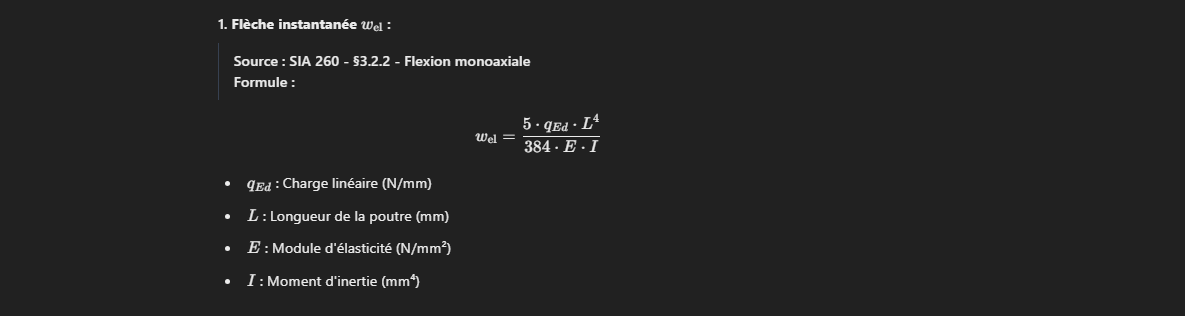
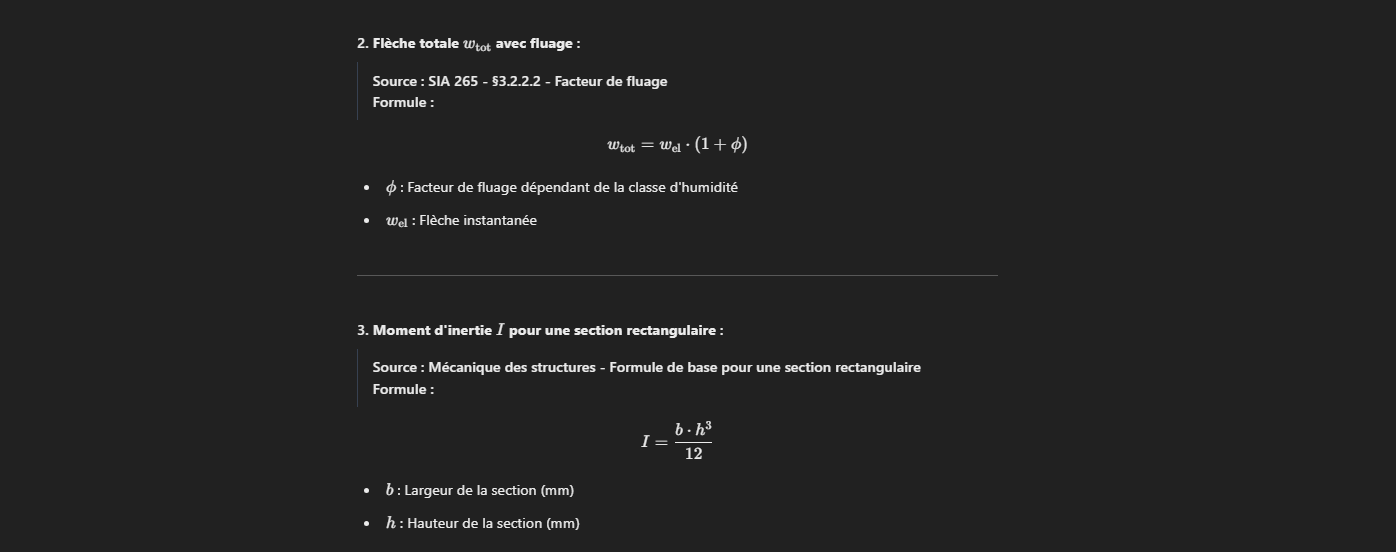
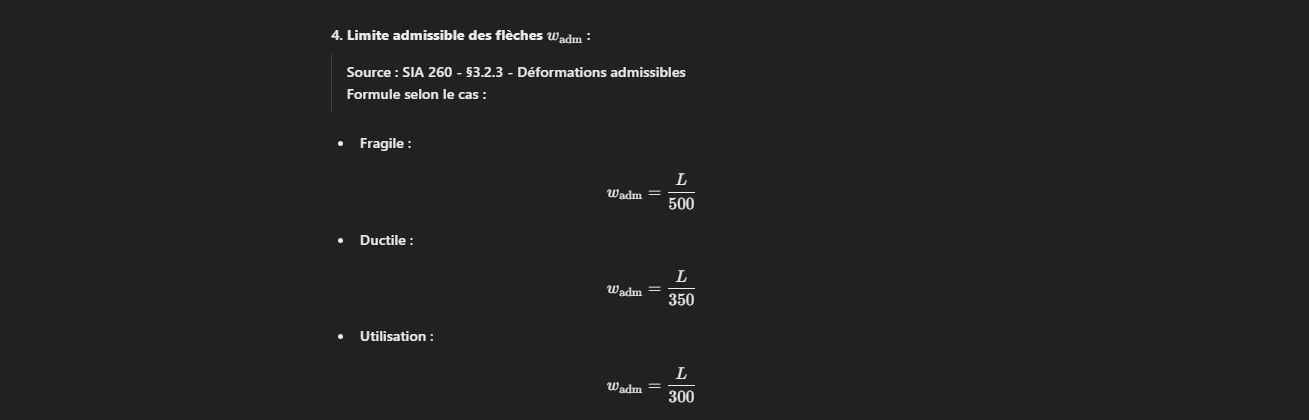
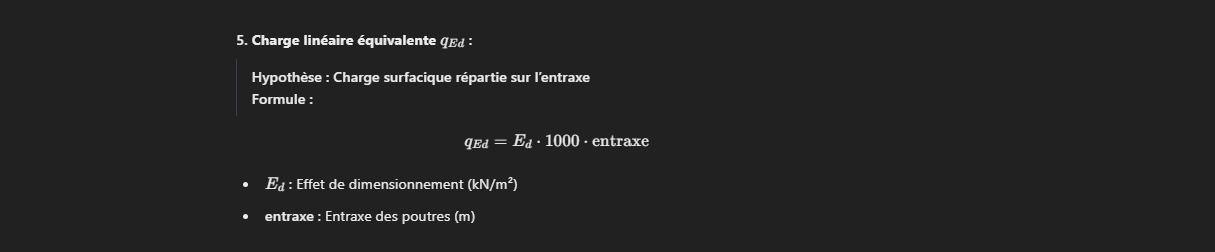
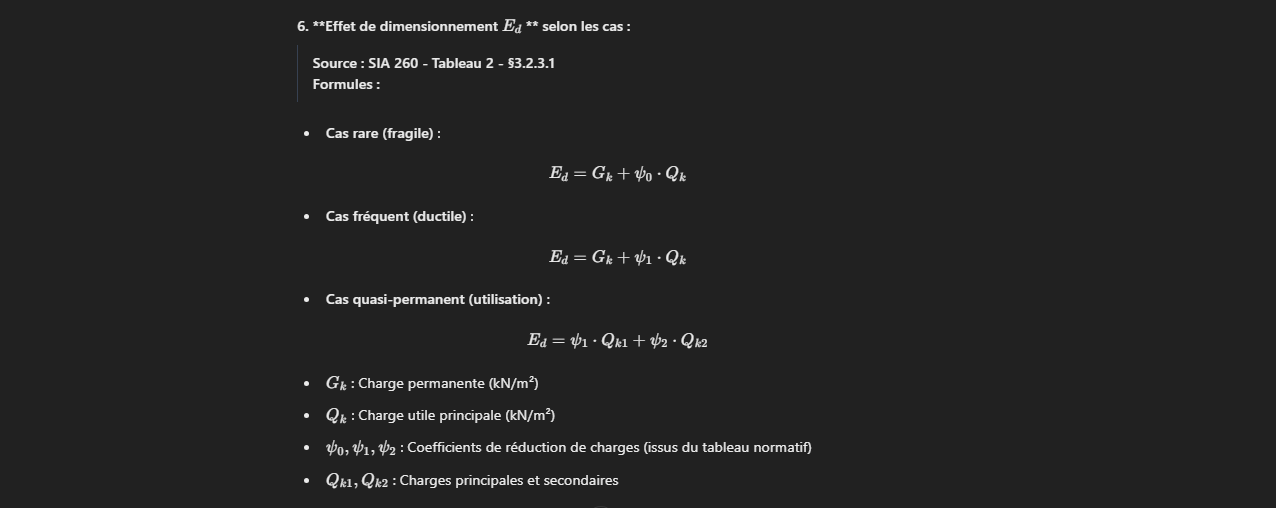
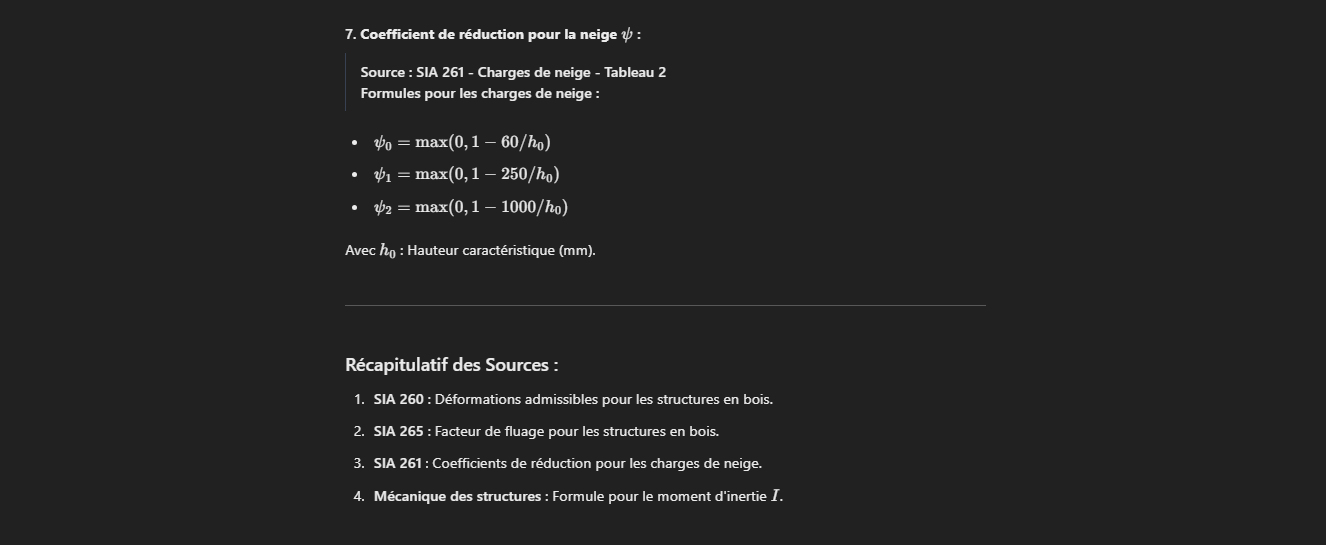

In [82]:
def calcul_hauteur_min(b, L, qEd, E, w_adm):
    """
    Calcule la hauteur minimale de la poutre pour respecter la flèche admissible.
    b : Largeur de la section (mm)
    L : Longueur de la poutre (mm)
    qEd : Charge linéaire (N/mm)
    E : Module d'élasticité (N/mm2)
    w_adm : Flèche admissible (mm)
    """
    h_min = ((15 * qEd * L**4) / (E * b * w_adm)) ** (1/3)
    return h_min
# Calcul de la hauteur minimale
h_min = calcul_hauteur_min(b, L, qEd, E, w_adm)

# Affichage du résultat
print(f"Hauteur minimale requise pour respecter la flèche admissible : {h_min:.2f} mm")


Hauteur minimale requise pour respecter la flèche admissible : 879.41 mm
